In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scripts.proportion_ztest import calculate
from scripts.ttest import calculate_ttest
from scripts.data_loader import load_postgres_table, load_csv_data
from scripts.ab_distribution import calculate_ab_distribution
from scripts.ab_retention import calculate_retention
from scripts.data_cleaner import get_outliers_count, clean_dataset, calculate_zero_players
from scripts.data_segment_analyze import get_late_starters, get_loyal_users, analyze_segment

# Reading dataset from postgresql database
# df = load_postgres_table('cookiecats', 'cookie_cats')

# Reading dataset from csv
df = load_csv_data('cookie_cats.csv')

# Show hew elements from begining
df.head()

,userid,test_version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [2]:
#Check shape of database
df.shape

(90189, 5)

In [3]:
#main information about database
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
#Check null elements count in database
df.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [7]:
# group distribution check
distribution = calculate_ab_distribution(df, 'test_version', 'userid')
display(distribution)

difference = abs(distribution['percent'].iloc[0] - distribution['percent'].iloc[1])
print(f'The groups are almost perfectly balanced. Difference is: {difference.round(2)}%')

,test_version,number_of_players,percent
0,gate_30,44700,49.56
1,gate_40,45489,50.44


The groups are almost perfectly balanced. Difference is: 0.88%


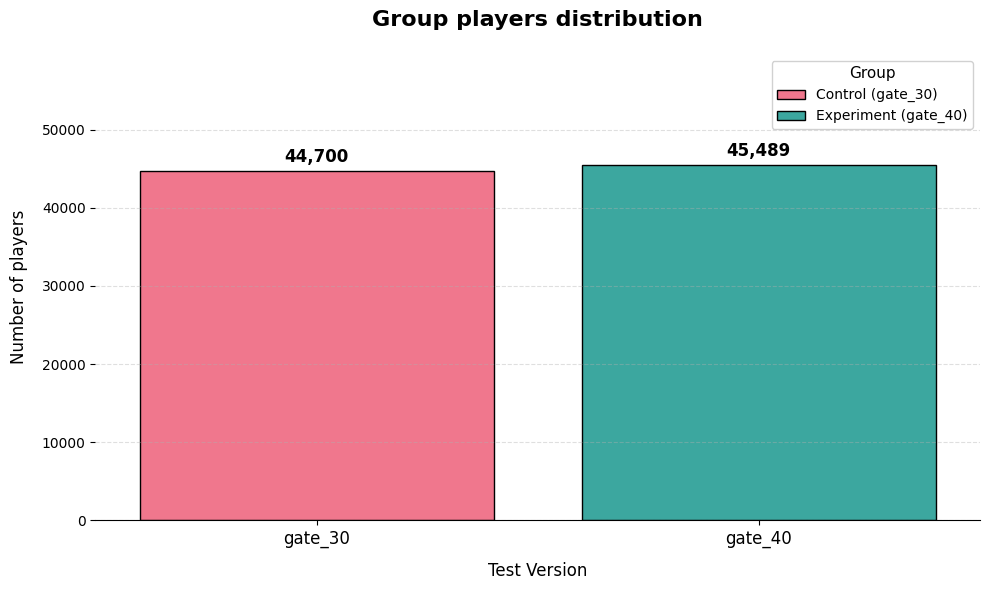

In [98]:
plt.figure(figsize=(10, 6))
palette = sns.color_palette("husl", n_colors=len(df['test_version'].unique()))

ax = sns.countplot(x='test_version', data=df, 
                  palette=palette,
                  saturation=0.9,
                  edgecolor='black',
                  linewidth=1,
                  legend=True,
                  hue='test_version')

for p in ax.patches:
    if p.get_height() == 0:
        continue
    ax.annotate(f'{p.get_height():,.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize=12,
                fontweight='bold')

ax.set_title('Group players distribution', fontsize=16, pad=20, fontweight='bold')
ax.set_xlabel('Test Version', fontsize=12, labelpad=10)
ax.set_ylabel('Number of players', fontsize=12, labelpad=10)

ax.set_xticks(ax.get_xticks()) 
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)

ax.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine(left=True)

ax.legend(
    title='Group', 
    labels=['Control (gate_30)', 'Experiment (gate_40)'],
    title_fontsize=11,
    fontsize=10,
    framealpha=0.9,
    loc='upper right'
)

#Small increase for correct legend positioning
ax.set_ylim(top=ax.get_ylim()[1]*1.25)

plt.tight_layout()
plt.show()

In [8]:
#retention by group
ret_table = calculate_retention(df, 'test_version', ['retention_1', 'retention_7'])
ret_table.round(2)

,test_version,retention_1,retention_7
0,gate_30,44.82,19.02
1,gate_40,44.23,18.20
0,difference,0.59,0.82


In [18]:
print('Retention of day 1, day 7 is higher in gate_30 group')

Retention of day 1, day 7 is higher in gate_30 group


In [9]:
final_table = calculate_zero_players(df, 'test_version', 'userid', 'sum_gamerounds')
display(final_table)

total_players = final_table['total_players'].iloc[:2].tolist()
total_zero_players = final_table['zero_players_count'].iloc[:2].tolist()

p_value = calculate(total_zero_players, total_players)
p_value

final_table['p_value'] = ['-', p_value.round(2)]
print(final_table)
print('There is no statistical significance among players who did not complete any levels')

,test_version,total_players,zero_players_count,percent
0,gate_30,44700,1937,4.33
1,gate_40,45489,2057,4.52


Z-статистика: -1.377, p-value: 0.169
  test_version  total_players  zero_players_count  percent p_value
0      gate_30          44700                1937     4.33       -
1      gate_40          45489                2057     4.52    0.17
There is no statistical significance among players who did not complete any levels


count    44700.000000
mean        52.456264
std        256.716423
min          0.000000
25%          5.000000
50%         17.000000
75%         50.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64
count    45489.000000
mean        51.298776
std        103.294416
min          0.000000
25%          5.000000
50%         16.000000
75%         52.000000
max       2640.000000
Name: sum_gamerounds, dtype: float64


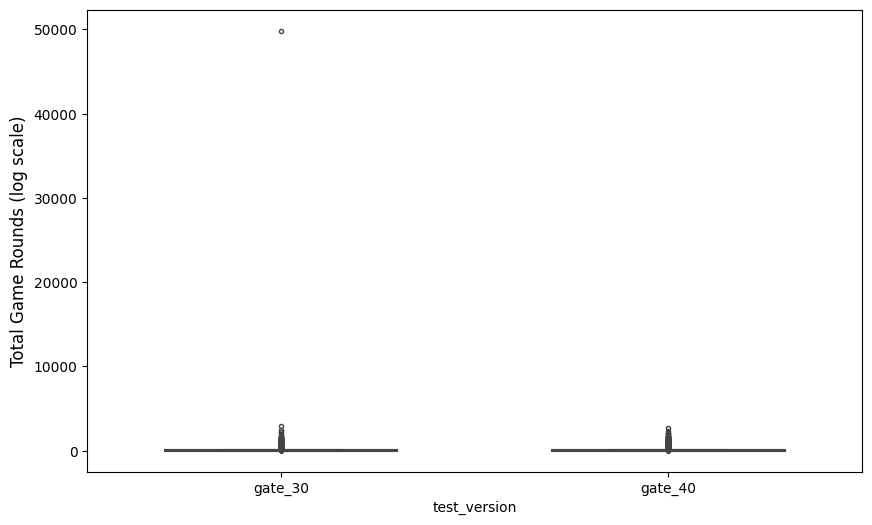

As we see in chart - there a some outliers count with huge amount of levels


In [35]:
plt.figure(figsize=(10, 6))  # Размер графика

metrics_30 = df[df['test_version']=='gate_30']['sum_gamerounds'].describe()
metrics_40 = df[df['test_version']=='gate_40']['sum_gamerounds'].describe()
print(metrics_30)
print(metrics_40)

#Chart with levels stats without outliers
palette = sns.color_palette("husl", n_colors=len(df['test_version'].unique()))
box = sns.boxplot(
    data=df,
    x="test_version",
    y="sum_gamerounds",
    hue='test_version',
    palette=palette,
    width=0.6,
    linewidth=1.5,
    fliersize=3,  # Размер точек выбросов
    showfliers=True
)

plt.ylabel('Total Game Rounds (log scale)', fontsize=12)

plt.show()
print('As we see in chart - there a some outliers count with huge amount of levels')

In [25]:
outliers = df.groupby('test_version')['sum_gamerounds'].quantile(0.99).round(2)
print(
    f"Hardcore players' behavior is similar in both groups: \n"
    f"- gate_30: {outliers['gate_30']} rounds (99th percentile)\n"
    f"- gate_40: {outliers['gate_40']} rounds (99th percentile)\n"
    "Conclusion: Outliers can be removed based on the global 99th percentile."
)

Hardcore players' behavior is similar in both groups: 
- gate_30: 493.0 rounds (99th percentile)
- gate_40: 492.12 rounds (99th percentile)
Conclusion: Outliers can be removed based on the global 99th percentile.


In [2]:
#Remove outliers
initial_count = len(df)
outliers_count = get_outliers_count(df, 'sum_gamerounds', 0.99)

print(
    f"\nData cleaning:\n"
    f"- Initial dataset: {initial_count} players\n"
    f"- Outliers removed: {outliers_count} players (top 1% by 'sum_gamerounds')\n"
    f"- Clean dataset: {initial_count - outliers_count} players remaining"
)

# Apply filtering (keep only non-zero and non-outliers)
clean_df = clean_dataset(df, 'sum_gamerounds', 0.99, True)
clean_df.head()


Data cleaning:
- Initial dataset: 90189 players
- Outliers removed: 906 players (top 1% by 'sum_gamerounds')
- Clean dataset: 89283 players remaining


,userid,test_version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [20]:
#Sensitivity Analysis
group = df.groupby('test_version')['retention_1'].mean().mul(100).reset_index(name = 'retention_1')
print(group)

group_without_outliers = clean_df.groupby('test_version')['retention_1'].mean().mul(100).reset_index(name = 'retention_1')
print(group_without_outliers)

difference_initial = group['retention_1'].iloc[0].round(2) - group['retention_1'].iloc[1].round(2)
difference_without_outliers = group_without_outliers['retention_1'].iloc[0].round(2) - group_without_outliers['retention_1'].iloc[1].round(2)

data = {
    'Metric': ['Retention 1 day', 'Difference'],
    'All users': [f'{group['retention_1'].iloc[0].round(2)} vs {group['retention_1'].iloc[1].round(2)}', difference_initial],
    'Without outliers': [f'{group_without_outliers['retention_1'].iloc[0].round(2)} vs {group_without_outliers['retention_1'].iloc[1].round(2)}', difference_without_outliers]
}

sensitivity_frame = pd.DataFrame(data)
sensitivity_frame.set_index('Metric', inplace=True)
print(sensitivity_frame)
print("Sensitivity Analysis result: the effect is stable on any calculation")

  test_version  retention_1
0      gate_30    44.818792
1      gate_40    44.228275
  test_version  retention_1
0      gate_30    46.216203
1      gate_40    45.670940
                      All users Without outliers
Metric                                          
Retention 1 day  44.82 vs 44.23   46.22 vs 45.67
Difference                 0.59             0.55
Sensitivity Analysis result: the effect is stable on any calculation


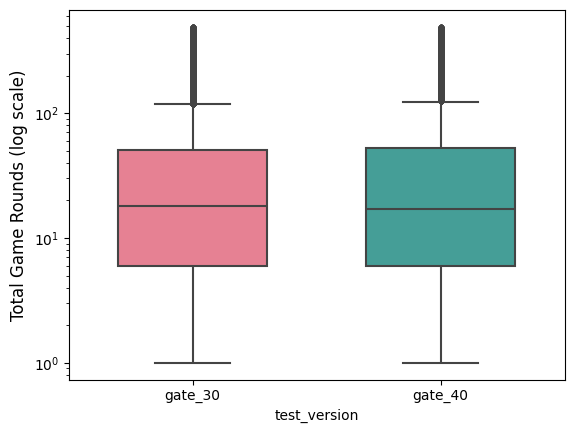

In [21]:
#Chart with levels stats without outliers
palette = sns.color_palette("husl", n_colors=len(df['test_version'].unique()))
box = sns.boxplot(
    data=clean_df,
    x="test_version",
    y="sum_gamerounds",
    hue='test_version',
    palette=palette,
    width=0.6,
    linewidth=1.5,
    fliersize=3,  # Размер точек выбросов
    showfliers=True
)

plt.yscale('log')
plt.ylabel('Total Game Rounds (log scale)', fontsize=12)

print('Chart shows the sum of game rounds in logariphmic scale (for clean view) after outliers removed')
plt.show()

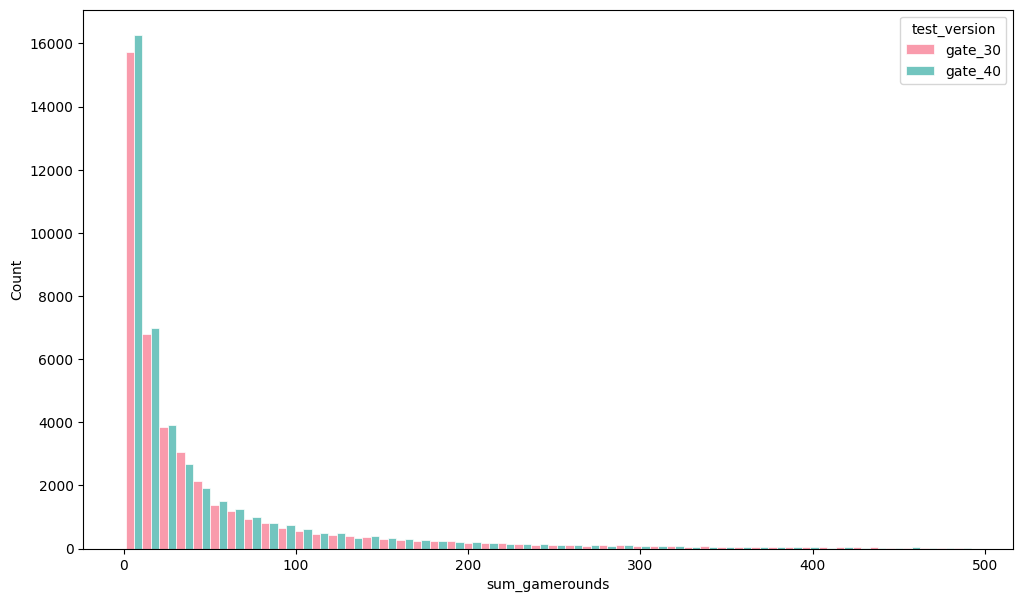

In [16]:
plt.figure(figsize=(12, 7))

palette = sns.color_palette("husl", n_colors=len(df['test_version'].unique()))
ax = sns.histplot(
    data=clean_df,
    x='sum_gamerounds',
    hue='test_version',    
    palette=palette,
    bins=50,                 
    alpha=0.7,
    edgecolor='white',
    linewidth=0.5,
    multiple='dodge'
)

plt.show()

In [27]:
print(
    'Users segmentation for behaviour analisys: \n'
    'Let\'s devide users into segments to estimate the average number of levels on the cleaned data. \n'
    '- The first segment includes late starters (retention_1 = false, retention_7 = true) \n'
    '- The second segment includes loyal users (retention_1 = true, retention_7 = true) \n'
    '- We will also analyze all users separately by the number of levels completed \n'
)

Users segmentation for behaviour analisys: 
Let's devide users into segments to estimate the average number of levels on the cleaned data. 
- The first segment includes late starters (retention_1 = false, retention_7 = true) 
- The second segment includes loyal users (retention_1 = true, retention_7 = true) 
- We will also analyze all users separately by the number of levels completed 



In [3]:
#Late starters analisys
#retention_1 = false, retention_7 = true
#example for data without outliers remove

late_starters = get_late_starters(df)
print(late_starters.head())

avg_levels = late_starters.groupby('test_version').agg(
    avg_levels = ('sum_gamerounds', 'mean')
)

print(avg_levels)
print('Here is incorrect result because of outliers')
print('Mistake in result that gate_30 better then gate_40 by avg levels')

     userid test_version  sum_gamerounds  retention_1  retention_7
10     1842      gate_40               3        False         True
23     2729      gate_30             105        False         True
90     8788      gate_30              19        False         True
102   10200      gate_40             106        False         True
143   13429      gate_30              60        False         True
              avg_levels
test_version            
gate_30       100.431544
gate_40        75.261139
Here is incorrect result because of outliers
Mistake in result that gate_30 better then gate_40 by avg levels


In [8]:
#Late starters analisys
#retention_1 = false, retention_7 = true
#data without outliers

segment = get_late_starters(clean_df)
avg_levels = analyze_segment(segment)

print(avg_levels)
print('There is no statistical significance among late starters')

  test_version  players_count  avg_levels difference p_value t_value Cohen_s d
0      gate_30           1800       70.06          -       -       -         -
1      gate_40           1755       72.01       1.95   0.456  -0.746    -0.025
There is no statistical significance among late starters


In [5]:
#Loyal player analisys
segment = get_loyal_users(clean_df)
avg_levels = analyze_segment(segment)

print(avg_levels)
print(
    'Conclusions \n'
    '- No statistical significance (p = 0.079 > 0.05), but there is a trend: in `gate_40` players complete 3.5 more levels. \n'
    '- Effect size is weak (d = -0.03) — The effect is microscopic. \n'
    '- Test has sufficient power (n > 6,000 per group) → if the effect is real, we should have detected it. \n'
)

  test_version  players_count  avg_levels difference p_value t_value Cohen_s d
0      gate_30           6257      148.37          -       -       -         -
1      gate_40           6074      151.88       3.51   0.079  -1.758    -0.032
Conclusions 
- No statistical significance (p = 0.079 > 0.05), but there is a trend: in `gate_40` players complete 3.5 more levels. 
- Effect size is weak (d = -0.03) — The effect is microscopic. 
- Test has sufficient power (n > 6,000 per group) → if the effect is real, we should have detected it. 



In [7]:
avg_levels = analyze_segment(clean_df)

print(avg_levels)
print('p-value = 0.748. No statistical significance.')

  test_version  players_count  avg_levels difference p_value t_value Cohen_s d
0      gate_30          42312       46.65          -       -       -         -
1      gate_40          42977       46.49       0.16   0.748   0.321     0.002
p-value = 0.748. No statistical significance.


In [38]:
print('Although in the gate_40 group, loyal players complete 3.5 levels more (p=0.08), the effect is not statistically significant. The effect size is negligible (Cohen\'s d=-0.03) — there are practically no differences. \n')

print('According to the data from this report, the best decision at the moment would be to leave the gate at level 30. \n')

print(
    'I also observe that in production, gate is currently at level 40. \n'
    'Perhaps the decision to keep gate_40 was made based on unaccounted metrics (monetization, LTV, churn) or the results of later tests were different. There is no data in the current dataset to test these hypotheses.'
)

Although in the gate_40 group, loyal players complete 3.5 levels more (p=0.08), the effect is not statistically significant. The effect size is negligible (Cohen's d=-0.03) — there are practically no differences. 

According to the data from this report, the best decision at the moment would be to leave the gate at level 30. 

I also observe that in production, gate is currently at level 40. 
Perhaps the decision to keep gate_40 was made based on unaccounted metrics (monetization, LTV, churn) or the results of later tests were different. There is no data in the current dataset to test these hypotheses.
